<a href="https://colab.research.google.com/github/aishafarooque/Tweet-Intimacy-Analysis/blob/main/Aisha_NLP_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilingual Tweet Intimacy Analysis

## Introduction

Dataset created by: Jiaxin Pei, Francesco Barbieri, Vítor Silva, Maarten Bos, Yozen Liu, Leonardo Neves, David Jurgens

The goal of this project is to train machine learning (ML) models to recognize "intimacy" in text communications. The authors of this paper define intimacy as "closeness and interdependence, self-disclosure, and warmth or affection” expressed in the language used to communicate.

We have used two datasets, Reddit questions and Multilingual tweets, in this notebook. They have both been compiled by Pei et al. and are used to study if knowledge about intimacy levels of text communication can be transferred easily from tweets to questions or vice versa. 

(Aisha) leaving these sections here (out-of-order and brainstormed) to help us write the report. 

## Related Work
(Aisha) Fill in any related work if applicable. This should probably go in the report.

Leaving some links to clean and well-written notebooks we can use as references:
* https://github.com/nlptown/nlp-notebooks/blob/master/An%20Introduction%20to%20Word%20Embeddings.ipynb 
* https://github.com/nlptown/nlp-notebooks/blob/master/Discovering%20and%20Visualizing%20Topics%20in%20Texts%20with%20LDA.ipynb 


Install dependencies

In [ ]:
from IPython.display import clear_output 

! pip install --upgrade pip
! pip install transformers
! pip install tqdm

# (Aisha) Clear output because it tends to get long. 
# But these libraries are always successfully installed.
clear_output()

## Data

Downloading the Twitter dataset from the Multilingual Tweet Intimacy Analysis Codalab competition ([source](https://codalab.lisn.upsaclay.fr/competitions/7096#learn_the_details-overview)).

In [ ]:
# Remove Twitter's train.csv if it already exists
! rm -rf train.csv

# Download Twitter's training data
! wget https://raw.githubusercontent.com/aishafarooque/Tweet-Intimacy-Analysis/main/train.csv

# Rename train.csv -> twitter_train.csv for more clarity
! mv train.csv twitter_train.csv

--2022-12-03 22:05:50--  https://raw.githubusercontent.com/aishafarooque/Tweet-Intimacy-Analysis/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 813066 (794K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>] 794.01K  --.-KB/s    in 0.05s   

2022-12-03 22:05:50 (16.9 MB/s) - ‘train.csv’ saved [813066/813066]



Downloading the Reddit dataset from the author's GitHub repository: Quantifying-Intimacy-in-Language
 ([source](https://github.com/Jiaxin-Pei/Quantifying-Intimacy-in-Language/blob/main/data/annotated_question_intimacy_data.zip)).

In [ ]:
# Sanitze working directory
! rm -rf /content/__MACOSX
! rm -rf /content/annotated_question_intimacy_data

# Removing the .zip file if it already exists.
! rm -rf annotated_question_intimacy_data.zip

# Download the dataset from the author's GitHub repository.
! wget https://raw.githubusercontent.com/Jiaxin%2DPei/Quantifying%2DIntimacy%2Din%2DLanguage/main/data/annotated_question_intimacy_data.zip

# Unzip the file. 
! unzip /content/annotated_question_intimacy_data.zip

--2022-12-03 22:05:51--  https://raw.githubusercontent.com/Jiaxin%2DPei/Quantifying%2DIntimacy%2Din%2DLanguage/main/data/annotated_question_intimacy_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94741 (93K) [application/zip]
Saving to: ‘annotated_question_intimacy_data.zip’

annotated_question_ 100%[===================>]  92.52K  --.-KB/s    in 0.01s   

2022-12-03 22:05:51 (6.41 MB/s) - ‘annotated_question_intimacy_data.zip’ saved [94741/94741]

Archive:  /content/annotated_question_intimacy_data.zip
   creating: annotated_question_intimacy_data/
  inflating: annotated_question_intimacy_data/final_train.txt  
   creating: __MACOSX/
   creating: __MACOSX/annotated_question_intimacy_data/
  inflating: __MACOSX/annotated_question_intimacy_data/._fin

## Data fact study

### Twitter Dataset

The Twitter dataset has a total of 9491 rows and 3 columns which are:
* Tweet - Textual content of the tweet
* Intimacy Label - Intimacy score of the tweet, ranging from 1 (least intimate) to 5 (most intimate).
* Language - The language the tweet is written in. There are six languages in this datasset:  English, Spanish, Italian, Portuguese, French, and Chinese.

In [ ]:
import pandas as pd

twitter_df_train = pd.read_csv('/content/twitter_train.csv', on_bad_lines='skip')
twitter_df_train = twitter_df_train.rename(columns={'text': 'document', 'label': 'label'})

print("Dataset size:", len(twitter_df_train), '\n')
twitter_df_train.info()

Dataset size: 9491 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9491 entries, 0 to 9490
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   document  9491 non-null   object 
 1   label     9491 non-null   float64
 2   language  9491 non-null   object 
dtypes: float64(1), object(2)
memory usage: 222.6+ KB


In [ ]:
twitter_df_train.sample(5)

,document,label,language
6935,@user Maxala en plus d’être toxique dans notre...,3.2,French
872,@user So can a bunch of NATO countries withdra...,1.0,English
397,@user Fine I'll just play rebirth with my 0 fr...,2.4,English
3411,@user Eu voto por #Dynamite do @BTS_twt pelo c...,1.0,Portuguese
1936,@user @user @TigresOficial Bien dicho no te ll...,1.8,Spanish


Looking at the distribution of tweets in the dataset we can see that, approximately, there are equal number of tweets across all six languages.

In [ ]:
tweet_distribution = twitter_df_train.groupby('language').count()['document']\
                      .reset_index().sort_values(by='document',ascending=False)
tweet_distribution.style.background_gradient()

,language,document
0,Chinese,1596
4,Portuguese,1596
5,Spanish,1592
2,French,1588
1,English,1587
3,Italian,1532


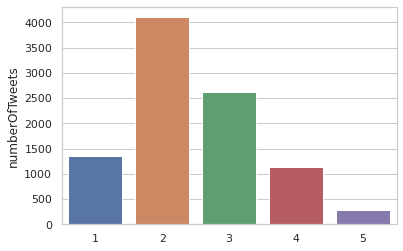

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")

df1 = twitter_df_train
bins = [0,1,2,3,4,5]
group_names=['1','2','3','4','5']
df1['numberOfTweets']=pd.cut(twitter_df_train['label'], bins, labels=group_names)

ax = sns.barplot(x=df1.numberOfTweets.value_counts().index, 
                 y=df1.numberOfTweets.value_counts(), 
                 data=df1)

### Reddit Dataset

The Reddit dataset has a total of 1797 rows and 2 columns which are:
* Question - Textual content of the Reddit question in English
* Intimacy Score - Intimacy score of the tweet, ranging from -1 (least intimate) to 1 (most intimate).

In [ ]:
reddit_df_train = pd.read_csv('/content/annotated_question_intimacy_data/final_train.txt', 
                              sep='\t', header=None, names=['document', 'label'])

print("Dataset size:", len(reddit_df_train), '\n')
reddit_df_train.info()

Dataset size: 1797 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   document  1797 non-null   object 
 1   label     1797 non-null   float64
dtypes: float64(1), object(1)
memory usage: 28.2+ KB


In [ ]:
reddit_df_train.head()

,document,label
0,What are the most mediocre animals in the anim...,-0.338354
1,What's the difference between an allergic reac...,0.035508
2,What is your favorite subreddit that not every...,0.047134
3,What's the most disgusting meal you've ever ea...,0.247764
4,Whats one question you hate being asked?,0.516920


#### Performing Linear Mapping on the Reddit Dataset

Since the ```intimacy_scores``` in the Reddit dataset is on a range from -1 to 1, we will linearly map them from 1 to 5. The linear mapping with maintain a constant ratio between the points. 

We will perform the following:
- A scaling operation to adjust the ranges to the same size, and
- An offset operation to adjust range alignment. 

Source: http://learnwebgl.brown37.net/08_projections/projections_mapping.html 

In [ ]:
A, B, C, D = -1, 1, 1, 5
scale = (D-C)/(B-A)
offset = -A*(D-C)/(B-A) + C

for index, row in reddit_df_train.iterrows():
  iScore = row['label']

  # If the cell is re-run without clearing local variables, we'll
  # double convert the values between the 1-5 range resulting in values between
  # 5-10. This condition makes sure original scores from Reddit are not already
  #  greater than 1. 
  if iScore > 1:
    break

  q = iScore * scale + offset
  reddit_df_train.at[index, 'label'] = round(q, 1)
  
reddit_df_train.head()

,document,label
0,What are the most mediocre animals in the anim...,2.3
1,What's the difference between an allergic reac...,3.1
2,What is your favorite subreddit that not every...,3.1
3,What's the most disgusting meal you've ever ea...,3.5
4,Whats one question you hate being asked?,4.0


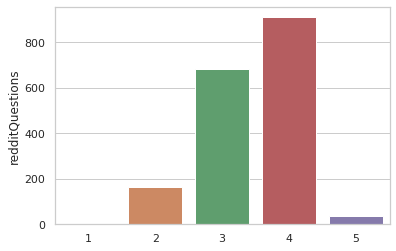

In [ ]:
df1 = reddit_df_train
bins = [0,1,2,3,4,5]
group_names=['1','2','3','4','5']
df1['redditQuestions']=pd.cut(reddit_df_train['label'],bins,labels=group_names)

ax = sns.barplot(x=df1.redditQuestions.value_counts().index, 
                 y=df1.redditQuestions.value_counts(), 
                 data=df1)

## Define the Tokenizer

In [ ]:
! pip install sentencepiece
! pip install transformers
! pip install seqeval
! pip install bertviz
! pip install datasets

# (Aisha) Clear output because it tends to get long. 
# But these libraries are always successfully installed.
clear_output()

In [ ]:
import datasets
import transformers

# set up verbosity of libraries
datasets.utils.logging.set_verbosity_error()
transformers.utils.logging.set_verbosity_error()

In [ ]:
import torch

# Set up device. Recommend to use GPU to accelerate training
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
PRETRAINED_MODEL_NAME = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"

IGNORE_INDEX = -100

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
tokenizer

Downloading:   0%|          | 0.00/841 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

PreTrainedTokenizerFast(name_or_path='cardiffnlp/twitter-xlm-roberta-base-sentiment', vocab_size=250002, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'})

## Data split

The data will be split into training and testing datasets.
The training dataset will be 80% of the data from the Reddit and Twitter datasets. This dataset will be used to fine tune the model. 

In [ ]:
# Declare constants for commonly used strings
TWEET = 'tweet'
REDDIT = 'reddit'
TRAIN = 'train'
TEST = 'test'
COMBINED = 'combined'

In [ ]:
def split_dataset(dataset, train_size, test_size):
  X = dataset['document']
  y = dataset['label']

  # Bin size = 1.0
  bins = np.linspace(start=1.0, stop=5.0, num=5)

  binned_y = np.digitize(y, bins)
  X_train, X_rem, y_train, y_rem = train_test_split(X, y, 
                                                    stratify=binned_y, 
                                                    train_size=train_size)

  binned_y_rem = np.digitize(y_rem, bins)
  X_test, X_valid, y_test, y_valid = train_test_split(X_rem, y_rem, 
                                                      stratify=binned_y_rem, 
                                                      test_size=test_size)
  
  print (f'X_train: {X_train.shape}, X_rem: {X_rem.shape}, y_train: {y_train.shape}, y_rem: {y_rem.shape}')
  print (f'X_test: {X_test.shape}, X_valid: {X_valid.shape}, y_test: {y_test.shape}, y_valid: {y_valid.shape}')
  
  return {'train': {'X': X_train, 'y': y_train},
          'test': {'X': X_test, 'y': y_test},
          'valid': {'X': X_valid, 'y': y_valid}}

In [ ]:
"""
Combines collections from the same split of two datasets into one collection to use as a split of the combined dataset.
"""
def combine_sets(a, b):
  # Simple concatenation. Is there another way we want to try combining them
  #  (e.g. zipping/mixing them together?)
  return [a_item for a_item in a] + [b_item for b_item in b]
  """
  Note(Orion:) this doesn't work because the documents are not simple lists!
  """

def combine_splits(a_split, b_split):
  return {split_name: {variable: combine_sets(a_split[split_name][variable], b_split[split_name][variable]) 
                       for variable in a_split[split_name]} 
          for split_name in a_split}

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Pull x and y values from dataframe
datasets = {'tweet': twitter_df_train, 'reddit': reddit_df_train}

# Define train:test:valid split ratios
split_ratios = {'tweet': {'train_total_ratio': 0.8,
                          'test_rem_ratio': 0.5},
                
                # Train:test:valid ratio of 8:1:1 for Reddit dataset
                'reddit': {'train_total_ratio': 0.8,
                           'test_rem_ratio': 0.5}}

# Split individual tweet/reddit datasets
split_datasets = {key: split_dataset(datasets[key], 
                                     split_ratios[key]['train_total_ratio'],
                                     split_ratios[key]['test_rem_ratio'])
                  for key in datasets}

# Create and split combined dataset
split_datasets['combined'] = combine_splits(split_datasets['tweet'], 
                                            split_datasets['reddit'])

X_train: (7592,), X_rem: (1899,), y_train: (7592,), y_rem: (1899,)
X_test: (949,), X_valid: (950,), y_test: (949,), y_valid: (950,)
X_train: (1437,), X_rem: (360,), y_train: (1437,), y_rem: (360,)
X_test: (180,), X_valid: (180,), y_test: (180,), y_valid: (180,)


In [ ]:
split_datasets.keys()

dict_keys(['tweet', 'reddit', 'combined'])

In [ ]:
print (f'Keys in {TWEET} are {split_datasets[TWEET].keys()}')
print (f'Keys in {REDDIT} are {split_datasets[REDDIT].keys()}')
print (f'Keys in {COMBINED} are {split_datasets[COMBINED].keys()}')

Keys in tweet are dict_keys(['train', 'test', 'valid'])
Keys in reddit are dict_keys(['train', 'test', 'valid'])
Keys in combined are dict_keys(['train', 'test', 'valid'])


In [ ]:
# Ensure the features were correctly combines
features_in_twitter = len(split_datasets[TWEET][TRAIN]['X'])
features_in_reddit = len(split_datasets[REDDIT][TRAIN]['X'])
features_in_combined = len(split_datasets[COMBINED][TRAIN]['X'])

assert features_in_combined == (features_in_twitter + features_in_reddit), f'Features do not match'

# Ensure the labels were correctly combined
labels_in_twitter = len(split_datasets[TWEET][TRAIN]['y'])
labels_in_reddit = len(split_datasets[REDDIT][TRAIN]['y'])
labels_in_combined = len(split_datasets[COMBINED][TRAIN]['y'])

assert labels_in_combined == (labels_in_twitter + labels_in_reddit), f'Labels do not match'

After splitting the dataset, we will be left with the following structure:

```
split_datasets
├── tweet
│   ├── train
│   │   ├── X
│   │   └── y
│   ├── test
│   └── valid
├── reddit
│   ├── train
│   ├── test
│   └── valid
└── combined
    ├── train
    ├── test
    └── valid
```





## Research regarding data and data split

Pei and Jurgens (2020) conducted analyses for an issue in pre-processing, where they were only able to do it for 1,000 tweets. They found that the distribution of the final annotated intimacy scores are not changed much while the fine-tuned XLM-T only achieved a Pearson’s r of 0.43 on the random sample, suggesting that the model trained on Reddit questions may not be reliable enough to detect intimacy in tweets. A potential goal of ours is too improve upon this making the model reliable for even reddit questions.

(Liu et al., 2019) include two variants: one which is fine-tuned on 3M unannotated questions on a masked language modeling task, and a second which uses the default parameters in RoBERTa. Training uses only the 2,247 annotated Reddit questions, split 8:1:1 into training, validation, and test.


## Preparing data

Before sending the data to the model, we will preprocess it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define the datasets

We will have identifiers for each word in a language produced by tokenization. During this process, chunks of words, such as a sentence or a phrase, are broken down into smaller units. Each unit is called a token which could be words, numbers, or punctuation marks. 

Any word not in our dictionary will be replaced with the `unknown` token. 

Reference:
- [Tokenizer - huggingface.co](https://huggingface.co/docs/transformers/main_classes/tokenizer)

In [ ]:
def tokenize_catch_unknown(word, tokenizer, vocab):
  """
  Description: Tokenizes a word if it is known, but catches unknown words and replaces it with unknown tokens.
  
  """
  if vocab.get(word):
    return tokenizer.tokenize(word)
  else:
    return [tokenizer.unk_token]

In [ ]:
def prepare_document_encoding(document, tokenizer, vocab):
  """
  Description: Converts one document (a tweet or other text) into tokens in the model's vocabulary.
  Returns a dictionary containing the tokens as text, the numerical ids of the tokens, and the score label for the document (already numerical here)

  """
  tokenized = [tokenizer.cls_token] + [token for word in document for token in tokenize_catch_unknown(word, tokenizer, vocab)]
  input_ids = [tokenizer.convert_tokens_to_ids(token) for token in tokenized]

  return {"tokenized": tokenized, 
          "input_ids": input_ids}


In [ ]:
def prepare_data(data, tokenizer, vocab):
  """
  Description: Converts the documents in the data into tokens in the model's vocabulary.

  """
  for split in data:
    data[split]['tokenized'] = []
    data[split]['input_ids'] = []
    data[split]['labels'] = []

    for document, label in zip(data[split]['X'], data[split]['y']):
      prepared_document = prepare_document_encoding(document, tokenizer, vocab)

      data[split]['tokenized'] += [prepared_document['tokenized']]
      data[split]['input_ids'] += [prepared_document['input_ids']]
      data[split]['labels'] += [label]

  return data


In [ ]:
import torch
from torch.utils.data import Dataset

class IADataset(Dataset):
  def __init__(self, data, pad_token_id):
        self.tokenized = data['tokenized']
        self.input_ids = data['input_ids']
        self.labels = data['labels']

        self.pad_token_id = pad_token_id
  
  def __len__(self):
        return len(self.input_ids)

  def __getitem__(self, index):
        return self.input_ids[index], self.labels[index]

  # Try without batch collation
  def collate_fn(self, batch):
        """
        Description:
            This function collates lists of samples into batches. It should be passed as the `collate_fn` argument when creating dataloaders.
        Inputs:
            - batch (List[Tuple]): a list of tuples. The tuple (Tuple[List]) in the batch is the return value (List[List]) of 
              `__getitem(self, index)` function. The elements are: 1) a List[int] (input_ids) and 2) a real (label).
        Outputs:
            - input_dict (Dict[str, torch.LongTensor]): a dictionary containing a mapping between input names and input values. The `input_ids` 
              (torch.LongTensor of shape (batch_size, sequence_length)) and `labels` (torch.FloatTensor of shape (batch_size, sequence_length)) 
              in the dictionary are token indexes and label values, respectively.
        """

        # unwrap the batch into every field
        input_ids, labels = map(list, zip(*batch))

        max_length = max(map(len, input_ids))

        padded_input_ids = [i + [self.pad_token_id] * (max_length - len(i)) for i in input_ids]
        attention_masks = [[1 for id in i] + [0] * (max_length - len(i)) for i in input_ids]

        input_dict = {
            'input_ids': torch.tensor(padded_input_ids).long(),
            'attention_masks': torch.tensor(attention_masks).long(),
            'labels': torch.tensor(labels).to(torch.float64)
        }

        return input_dict

In [ ]:
def get_ia_splits(data, pad_token_id):
  """
  Description: Creates IADatasets around each split of the dataset.
  """
  ia_splits = {split: IADataset(data[split], pad_token_id)
                  for split in data}

  return ia_splits

In [ ]:
# Convert the documents into sequences of input ids in the model's vocabulary
vocab = tokenizer.get_vocab()

# prepared_datasets = {key: prepare_data(split_datasets[key], tokenizer, vocab) for key in split_datasets}

import pickle
with open('/content/drive/Shareddrives/tesrt/nlp_final/objs.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    prepared_datasets = pickle.load(f)

prepared_datasets.keys()

dict_keys(['tweet', 'reddit', 'combined'])

In [ ]:
assert len(prepared_datasets[TWEET][TRAIN]['X']) == features_in_twitter, f"Mismatched sizes, expected {features_in_twitter}, got {len(prepared_datasets[TWEET][TRAIN]['X'])}"
assert len(prepared_datasets[REDDIT][TRAIN]['X']) == features_in_reddit, f"Mismatched sizes, expected {features_in_reddit}, got {len(prepared_datasets[REDDIT][TRAIN]['X'])}"
assert len(prepared_datasets[COMBINED][TRAIN]['X']) == features_in_combined, f"Mismatched sizes, expected {features_in_combined}, got {len(prepared_datasets[COMBINED][TRAIN]['X'])}"

assert len(prepared_datasets[TWEET][TRAIN]['y']) == labels_in_twitter, f"Mismatched sizes, expected {labels_in_twitter}, got {len(prepared_datasets[TWEET][TRAIN]['y'])}"
assert len(prepared_datasets[REDDIT][TRAIN]['y']) == labels_in_reddit, f"Mismatched sizes, expected {labels_in_reddit}, got {len(prepared_datasets[REDDIT][TRAIN]['y'])}"
assert len(prepared_datasets[COMBINED][TRAIN]['y']) == labels_in_combined, f"Mismatched sizes, expected {labels_in_combined}, got {len(prepared_datasets[COMBINED][TRAIN]['y'])}"


In [ ]:
ia_datasets = {key: get_ia_splits(prepared_datasets[key], 
                                    pad_token_id=tokenizer.pad_token_id) 
               for key in prepared_datasets}
ia_datasets

{'tweet': {'train': <__main__.IADataset at 0x7f2e988fbbb0>,
  'test': <__main__.IADataset at 0x7f2e988fbd00>,
  'valid': <__main__.IADataset at 0x7f2e988fb1f0>},
 'reddit': {'train': <__main__.IADataset at 0x7f2e988fbdc0>,
  'test': <__main__.IADataset at 0x7f2dcd099f40>,
  'valid': <__main__.IADataset at 0x7f2dcd099c10>},
 'combined': {'train': <__main__.IADataset at 0x7f2dcd099520>,
  'test': <__main__.IADataset at 0x7f2dcd099370>,
  'valid': <__main__.IADataset at 0x7f2dcd099550>}}

In [ ]:
print ('--TRAIN--')
print (f'IA Dataset Twitter length: {len(ia_datasets[TWEET][TRAIN].tokenized)}')
print (f'IA Dataset Reddit length: {len(ia_datasets[REDDIT][TRAIN].tokenized)}')
print (f'IA Dataset combined length: {len(ia_datasets[COMBINED][TRAIN].tokenized)}')

print ('--TEST--')
print (f'IA Dataset Twitter length: {len(ia_datasets[TWEET][TEST].tokenized)}')
print (f'IA Dataset Reddit length: {len(ia_datasets[REDDIT][TEST].tokenized)}')
print (f'IA Dataset combined length: {len(ia_datasets[COMBINED][TEST].tokenized)}')

assert len(ia_datasets[TWEET][TRAIN].tokenized) == features_in_twitter, f"Mismatched sizes, expected {features_in_twitter}, got {len(ia_datasets[TWEET][TRAIN].tokenized)}"
assert len(ia_datasets[REDDIT][TRAIN].tokenized) == features_in_reddit, f"Mismatched sizes, expected {features_in_reddit}, got {len(ia_datasets[REDDIT][TRAIN].tokenized)}"
assert len(ia_datasets[COMBINED][TRAIN].tokenized) == features_in_combined, f"Mismatched sizes, expected {features_in_combined}, got {len(ia_datasets[COMBINED][TRAIN].tokenized)}"

--TRAIN--
IA Dataset Twitter length: 7592
IA Dataset Reddit length: 1437
IA Dataset combined length: 9029
--TEST--
IA Dataset Twitter length: 949
IA Dataset Reddit length: 180
IA Dataset combined length: 1129


The folder structure for `ia_datasets` will be:
```
ia_datasets
├── tweet
│   ├── train
│   │   ├── tokenized
│   │   ├── input_ids
│   │   ├── labels
│   │   └── pad_token_ids
│   ├── test
│   └── valid
├── reddit
└── combined
```

In [ ]:
# Cleanup to save RAM
del prepared_datasets
del split_datasets
del reddit_df_train
del twitter_df_train

import gc

gc.collect()

0

### Define the DataLoaders

Dataloaders are constructs of the PyTorch library which define and control data preprocessing. The data will be fed in batches to the model. This is important because it is inefficient to load the data altogether in memory at once. The size of the data loaded at any given time into memory is controlled by the `batch_size` which is 32 for the training, validation and testing datasets.  

Every DataLoader has a Sampler which is used internally to get the indices for each batch. 

The `SequentialSampler` iterates over the dataset in a sequential order. For example: `[1,2,3]` -> `1,2,3`. Here the `shuffle` parameter is set to `false`.

The `RandomSampler` is just like it's sequential counterpart, but with `shuffle=True`.


References:
- [torch.utils.data — PyTorch 1.13 documentation](https://pytorch.org/docs/stable/data.html)
- [SequentialSampler](https://www.scottcondron.com/jupyter/visualisation/audio/2020/12/02/dataloaders-samplers-collate.html#SequentialSampler)

In [ ]:
from torch.utils.data import BatchSampler, DataLoader, RandomSampler, SequentialSampler

def get_dataloaders(datasets, train_batch_size, eval_batch_size):
    """
    Description:
        This function implements batch training by creating dataloaders for datasets to acclerate training.
    Inputs:
        - datasets (Dict[str, Dict]): a dictionary containing a mapping between dataset names and dataset values. 
        - train_batch_size (int): an integer which is used as the batch size when creating the train dataloader
        - eval_batch_size (int): an integer which is used as the batch size when creating the validation and test dataloader
    """
    # Retrieve the dataset split labels ("train", "validation", "test")
    splits = datasets.keys()

    # Choose different parameters for each dataset split
    sampler_classes = {split: 
                       (RandomSampler if split == "train" else SequentialSampler) 
                       for split in splits}

    batch_sizes = {split: 
                   (train_batch_size if split == "train" else eval_batch_size) 
                   for split in splits}

    # Initialize the BatchSamplers with the differentiated parameters
    batch_samplers = {split: 
                      BatchSampler(sampler_classes[split](datasets[split]),
                                   batch_sizes[split],
                                   drop_last=False)
                      for split in splits}

    # Build the dataloaders from the initialized BatchSamplers and the custom collate_fn
    dataloaders = {split: 
                   DataLoader(datasets[split], 
                              batch_sampler=batch_samplers[split],
                              collate_fn=datasets[split].collate_fn)
                   for split in splits}

    return dataloaders

TRAIN_BATCH_SIZE = 16
EVAL_BATCH_SIZE = 16

dataloaders = {key: get_dataloaders(ia_datasets[key], train_batch_size=TRAIN_BATCH_SIZE, eval_batch_size=EVAL_BATCH_SIZE) 
               for key in ia_datasets}
dataloaders

{'tweet': {'train': <torch.utils.data.dataloader.DataLoader at 0x7f2dbd3b5730>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x7f2dbd3b5880>,
  'valid': <torch.utils.data.dataloader.DataLoader at 0x7f2dbd3b5910>},
 'reddit': {'train': <torch.utils.data.dataloader.DataLoader at 0x7f2dbd3b5be0>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x7f2dbd3b5c70>,
  'valid': <torch.utils.data.dataloader.DataLoader at 0x7f2dbd3b5d00>},
 'combined': {'train': <torch.utils.data.dataloader.DataLoader at 0x7f2dbd3b5fd0>,
  'test': <torch.utils.data.dataloader.DataLoader at 0x7f2dbd3410a0>,
  'valid': <torch.utils.data.dataloader.DataLoader at 0x7f2dbd341130>}}

Check to ensure that lengths of dataset are as expected.

In [ ]:
import math 

def check_size(dataType, partitionType):
  if partitionType == TRAIN: batchSize = TRAIN_BATCH_SIZE
  else: batchSize = EVAL_BATCH_SIZE

  got = len(dataloaders[dataType][partitionType])
  expected = math.ceil(len(ia_datasets[dataType][partitionType].tokenized)/batchSize)
  assert got == expected, f'Got {got}, expected {expected}'

  print (f'{dataType}\'s {partitionType} length is {expected}.')

for d in [TWEET, REDDIT, COMBINED]:
  for p in [TRAIN, TEST, 'valid']:
    check_size(d, p)
  print (f'{d} is good.\n')
    
print ('All good - sizes are as expected!')

tweet's train length is 475.
tweet's test length is 60.
tweet's valid length is 60.
tweet is good.

reddit's train length is 90.
reddit's test length is 12.
reddit's valid length is 12.
reddit is good.

combined's train length is 565.
combined's test length is 71.
combined's valid length is 71.
combined is good.

All good - sizes are as expected!


## RoBERTa Model Architecture

In [ ]:
from transformers import AutoConfig

# set up the configuration for BERT model
config = AutoConfig.from_pretrained(PRETRAINED_MODEL_NAME)
config

XLMRobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-xlm-roberta-base-sentiment",
  "architectures": [
    "XLMRobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 250002
}

#### RobERTa Regressor - New

In [ ]:
import torch

PRETRAINED_MODEL_NAME = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

In [ ]:
import torch.nn as nn
from transformers import XLMRobertaModel, XLMRobertaPreTrainedModel

class XLMRobertaRegressor(nn.Module):
    
    def __init__(self, pretrained_model_name_or_path, drop_rate=0.2, freeze_camembert=False):
      # super().__init__(config)

      # self.hidden_size = config.hidden_size

      # self.n_classes = 1

      # self.xlmroberta = XLMRobertaModel.from_pretrained(pretrained_model_name_or_path)

      # self.regressor = nn.Sequential(
      #       nn.Dropout(drop_rate),
      #       nn.Linear(self.hidden_size, self.n_classes))
        
      # self.loss_fct = nn.CrossEntropyLoss(reduction='sum')

        super(XLMRobertaRegressor, self).__init__()
        D_in, D_out = 768, 1
        
        self.xlmroberta = XLMRobertaModel.from_pretrained(pretrained_model_name_or_path)
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(D_in, D_out))


    def forward(self, input_ids, attention_masks):
        # outputs = self.xlmroberta(input_ids, attention_masks)
        # sequence_output = outputs[0]
        
        # logits = self.regressor(sequence_output)

        # loss = self.loss_fct(logits.view(-1), labels.view(-1))
        # return loss, logits

        outputs = self.xlmroberta(input_ids, attention_masks)
        class_label_output = outputs[1]
        outputs = self.regressor(class_label_output)
        return outputs

model = XLMRobertaRegressor(PRETRAINED_MODEL_NAME, drop_rate=0.2).to(DEVICE)

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

## Training and Evaluation

In [ ]:
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr=5e-5,
                  eps=1e-8)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup
epochs = 5
total_steps = len(dataloaders[TWEET][TRAIN]) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,       
                 num_warmup_steps=0, num_training_steps=total_steps)

loss_function = nn.MSELoss()

#### Training Loop

In [ ]:
from torch.nn.utils.clip_grad import clip_grad_norm
from tqdm import tqdm

def train(model, optimizer, scheduler, loss_function, epochs,       
          train_dataloader, device, clip_value=2):
  

    for epoch in range(epochs):
        print(f'Epoch #{epoch}')

        best_loss = 1e10
        model.train()

        for step, batch in enumerate(tqdm(train_dataloader)): 

            batch_inputs, batch_masks, batch_labels = \
                               tuple(batch[field].to(device) for field in batch)


            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)           
            
            outputs = outputs.to(torch.float64)
            batch_masks = batch_masks.to(torch.float64)

            loss = loss_function(outputs.squeeze(), 
                             batch_labels.squeeze())

            loss.backward()
            clip_grad_norm(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()
                
    return model


model_variants = {}

for datasetType in [TWEET, REDDIT]:
  print (f'Training on {datasetType}')
  model_variants[datasetType] = train(model, optimizer, scheduler, loss_function, epochs, 
              dataloaders[datasetType][TRAIN], DEVICE, clip_value=2)



Training on tweet
Epoch #0


  0%|          | 0/475 [00:00<?, ?it/s]<ipython-input-40-c693810ae34a>:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  clip_grad_norm(model.parameters(), clip_value)
100%|██████████| 475/475 [04:00<00:00,  1.98it/s]


Epoch #1


100%|██████████| 475/475 [04:01<00:00,  1.96it/s]


Epoch #2


100%|██████████| 475/475 [04:03<00:00,  1.95it/s]


Epoch #3


100%|██████████| 475/475 [04:03<00:00,  1.95it/s]


Epoch #4


100%|██████████| 475/475 [04:03<00:00,  1.95it/s]


Training on reddit
Epoch #0


100%|██████████| 90/90 [00:43<00:00,  2.07it/s]


Epoch #1


100%|██████████| 90/90 [00:43<00:00,  2.06it/s]


Epoch #2


100%|██████████| 90/90 [00:43<00:00,  2.07it/s]


Epoch #3


100%|██████████| 90/90 [00:44<00:00,  2.04it/s]


Epoch #4


100%|██████████| 90/90 [00:43<00:00,  2.07it/s]


Save models locally.

In [ ]:
# for name in [TWEET, REDDIT]:
#   torch.save(model_variants[name].state_dict(), '/content/drive/Shareddrives/tesrt/nlp_final/twitter_reddit_trained/model_state_dict_' + name)

#### Evaluation Loop

In [ ]:
def evaluate(model, dataloader, device):
    with torch.no_grad():

      model.to(device)

      model.eval()

      all_preds, all_truth = [], []
      for step, batch in enumerate(tqdm(dataloader)):
          batch_inputs, batch_masks, batch_labels = tuple(
              batch[field].to(device) for field in batch)

          preds = model(batch_inputs, batch_masks)

          for i in range(len(preds)):
              preds_i = preds[i]
              truth_i = batch['labels'][i].data.detach().cpu().tolist()

              all_preds.append(preds_i)
              all_truth.append(truth_i)

              del preds_i, truth_i
          
          del batch_inputs, batch_masks, batch_labels
          del preds
        
      return all_preds, all_truth

## Fine tuning

In the report (Liu et al., 2019)

Parameters 
batch size as 128 and learning rate as 0.0001 w/ max length set to 50
Adam (Kingma and Ba, 2014) used for optimization.
All the other hyperparameters and the model size are the same as the default roberta-base model

Training
trained model for 30 epochs selecting model with lowest MSE on validation set
fine-tuning process: followed all default settings recommended by Hugging Face.

tunning learning rate: 
0.0001 and 0.00001 both achieved good scores regarding MSE and Pearson r.

**Note:** here is where you can adjust the parameters for `learning_rate` and `num_epochs`.

#### Load pretrained model

In [ ]:
model_variants = {}

SAVED_MODEL_PATH = '/content/drive/Shareddrives/tesrt/nlp_final/twitter_reddit_trained/model_state_dict_'

for name in [TWEET, REDDIT]:
  model = XLMRobertaRegressor(PRETRAINED_MODEL_NAME, drop_rate=0.2).to(DEVICE)
  model.load_state_dict(torch.load(SAVED_MODEL_PATH + name,  map_location=torch.device('cpu')))
  model.eval()

  model_variants[name] = model

model_variants.keys()

dict_keys(['tweet', 'reddit'])

In [ ]:
from seqeval.metrics import classification_report
from tqdm import tqdm 

for name in [TWEET, REDDIT]:
  # Evaluate the model on the other dataset than the one it's trained on.
  other_name = (REDDIT if name is TWEET else TWEET)
  test_preds, test_truth = evaluate(model_variants[name], dataloaders[other_name]['test'], device=DEVICE)
  print(f"Classification Report for %s model on %s test set:", name, other_name)
  print(classification_report(test_truth, test_preds, digits=5, zero_division=0))

100%|██████████| 12/12 [01:29<00:00,  7.42s/it]

Classification Report for %s model on %s test set: tweet reddit


AttributeError: ignored

## Base Line

From 11/03's class during project proposal feedback

## State of the Art
From 11/03's class during project proposal feedback

State of the art model should be regarded as XLM-T mode : Multilingual RoBERTa model trained over 200M tweets. Although this model in particular perfromed poorly on languages; Chinese, Hindi, Dutch, Korean,

## Experiment 

Baseline models to test:
1. BERT (Devlin et al., 2018): multilingual
BERT model.
2. XLM-R (Conneau et al., 2019): multilingual
RoBERTa model.
3. XLM-T (Barbieri et al., 2021): Multilingual
RoBERTa model trained over 200M tweets.
4. DistillBERT (Sanh et al., 2019): Multilingual
distilled BERT model.
5. MiniLM (Wang et al., 2020): Multilingual
MiniLM model.

(Liu et al., 2019) found that XLM-T achieved the best performance over 7 languages, suggesting that domain specific language model training is beneficial for our tweet intimacy analysis task
(Liu et al., 2019) found that for zero-shot tasks, models has varying performances for different languages: The zero-shot performance is generally lower compared with the tasks with in-domain training. This suggests that the zero-shot task is challenging. We should explore different strategies to improve the zero-shot intimacy prediction performance.


In [ ]:
! pip install transformers
! pip install seqeval
! pip install bertviz

In [ ]:
import torch

# Set up device. Recommend to use GPU to accelerate training
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
DEVICE

In [ ]:
# specify which pre-trained BERT model to use
PRETRAINED_MODEL_NAME_OR_PATH = 'bert-base-cased'

# specify the value of `ignore_index`
IGNORE_INDEX = -100

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME_OR_PATH)
tokenizer

## Testing

## Conclusion

Notes from 11/15's class Bias in NLP - 
- Are there are biases in this model?
- Are there subsets of human factors which we may encounter in these datasets that may contribute to biases?

## References